Let's first try if the functionality works


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

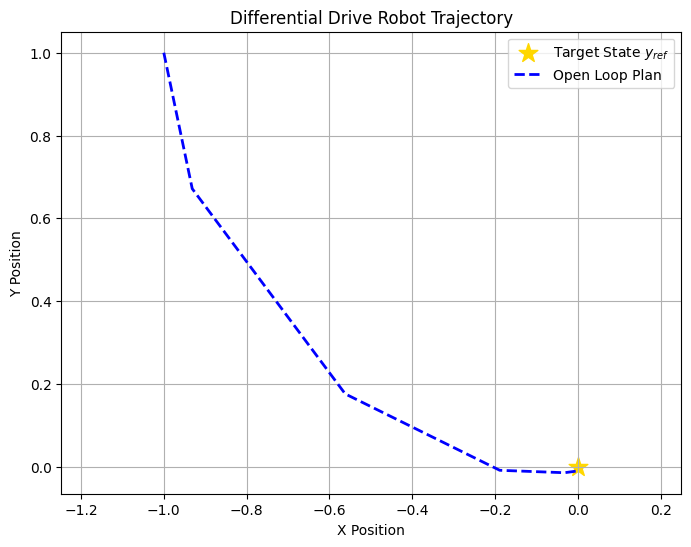


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

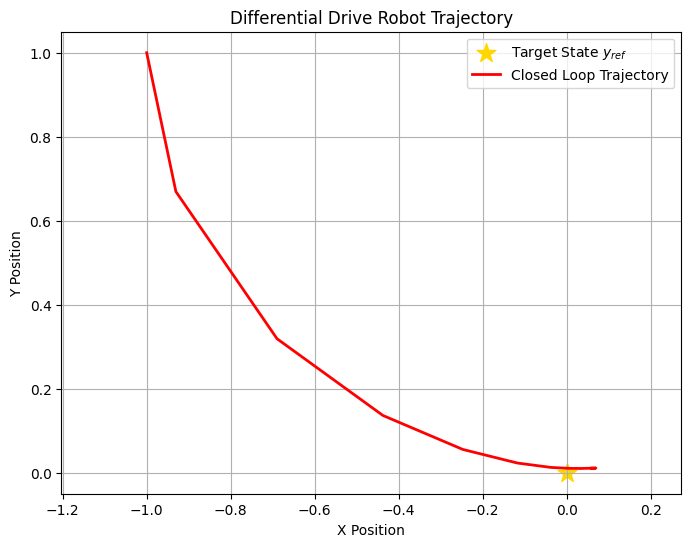

In [1]:

from Differential_drive_MPC import DifferentialDriveMPC, DifferentialDriveMPCOptions
import numpy as np
from utils_diff_drive import simulate_closed_loop
from plotting_utils_diff_drive import plot_diff_drive_trajectory

# Compile MPC

mpc_opts = DifferentialDriveMPCOptions()
mpc_opts.N = 50
mpc_opts.step_sizes = [1.0]*50
mpc_opts.switch_stage = 501
# mpc_opts.ellipse_centers = np.array([
#         [-0.5, 0.3],  # Center of first ellipse
#     ])
# mpc_opts.ellipse_half_axes = np.array([
#         [0.01, 0.01],   # Half-axis lengths (a, b) for first ellipse
#     ])
mpc = DifferentialDriveMPC(mpc_opts)

print("Acados compiles sucessfully")

# call solve for given initial state
X0 = np.array([-1.0, 1.0, 0.0, -np.pi/2, 0.0, 0.0, 0.0])  #np.array([1.0, 0.0, 0.0, np.pi, 0.0, 0.0, 0.0])  # Intital state
mpc.solve(X0)
print("Solve runs through succesfully")

# Visualize open loop plan
traj_x, traj_u = mpc.get_planned_trajectory()
print(traj_u)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc, open_loop_plan=np.array(traj_x))

# Try simulation in closed loop
duration = 20
if True:

    mpc_opts_sim = DifferentialDriveMPCOptions()
    mpc_opts_sim.N = 1
    mpc_opts_sim.step_sizes = [0.01]*1
    mpc_opts_sim.switch_stage = 2
    mpc_sim = DifferentialDriveMPC(mpc_opts_sim)
    x_traj, u_traj, stage_costs = simulate_closed_loop(X0, mpc, duration, sim_solver=mpc_sim.acados_sim_solver)
    print("Closed loop sim runs through succesfully")

    plot_diff_drive_trajectory(np.zeros(2), mpc=mpc, closed_loop_traj=x_traj)





got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

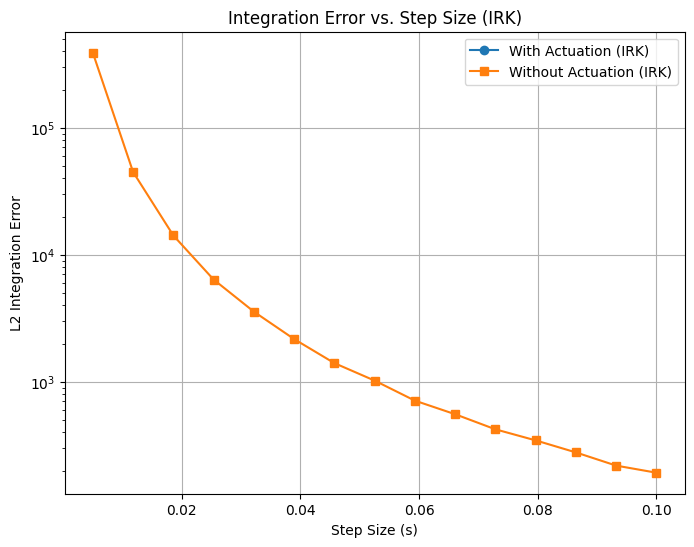

In [2]:
import numpy as np
import matplotlib.pyplot as plt

####################
# 1) Setup Acados Simulators
####################

def create_sim_solver(model_type, step_size):
    """
    Creates an Acados simulation solver with the given step size.
    model_type: 'full' (with actuation) or 'reduced' (no actuation).
    step_size: integration step size.
    """
    options = DifferentialDriveMPCOptions()
    options.step_sizes = [step_size] * options.N  # Use uniform step size
    options.integrator_type = "IRK"  # Use IRK

    if model_type == "full":
        mpc = DifferentialDriveMPC(options)
        return mpc.acados_sim_solver, 7  # Full model has 7 states
    elif model_type == "reduced":
        mpc = DifferentialDriveMPC(options)
        return mpc.acados_sim_solver_no_act, 5  # Reduced model has 5 states
    else:
        raise ValueError("Unknown model type: Choose 'full' or 'reduced'.")


def simulate_with_acados(sim_solver, X0, U, T_end, nx):
    """
    Simulates the system forward using AcadosSimSolver.
    sim_solver: Acados simulation solver.
    X0: Initial state (correct size).
    U: Constant control input.
    T_end: Simulation duration.
    nx: Number of states for the specific model.
    """
    sim_solver.set("x", np.reshape(X0, (nx, )))  # Ensure correct shape
    sim_solver.set("u", U)

    t_values = [0.0]
    X_values = [X0]
    step_size = sim_solver.acados_sim.solver_options.T
    num_steps = int(T_end / step_size)

    for _ in range(num_steps):
        status = sim_solver.solve()
        if status != 0:
            print(f"Simulation failed with status {status}")
            break
        X_new = sim_solver.get("x")
        X_values.append(X_new)
        t_values.append(t_values[-1] + step_size)
        sim_solver.set("x", X_new)  # Set new initial condition for next step

    return np.array(t_values), np.array(X_values)


####################
# 2) Compute Ground Truth with Small Step Size
####################
T_end = 2.0
X0_full = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # Full model (7 states)
X0_reduced = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # Reduced model (5 states)
U_full = np.array([5.0, 5.0])  # Voltage input
U_reduced = np.array([10.0, 10.0])  # Torque input

fine_step = 0.001  # Very small step size for ground truth
sim_solver_full, nx_full = create_sim_solver("full", fine_step)
t_fine, X_fine = simulate_with_acados(sim_solver_full, X0_full, U_full, T_end, nx_full)
x1_fine, x2_fine = X_fine[:, 0], X_fine[:, 1]

####################
# 3) Simulate With Different Step Sizes
####################

step_sizes = np.linspace(0.005, 0.1, 15)  # Different step sizes from 5ms to 100ms
errors_full, errors_reduced = [], []

for dt in step_sizes:
    # (a) Simulate the full model
    sim_solver_full, nx_full = create_sim_solver("full", dt)
    t_coarse_full, X_coarse_full = simulate_with_acados(sim_solver_full, X0_full, U_full, T_end, nx_full)
    del sim_solver_full
    x1_coarse_full, x2_coarse_full = X_coarse_full[:, 0], X_coarse_full[:, 1]

    # (b) Simulate the reduced model
    sim_solver_reduced, nx_reduced = create_sim_solver("reduced", dt)
    t_coarse_red, X_coarse_red = simulate_with_acados(sim_solver_reduced, X0_reduced, U_reduced, T_end, nx_reduced)
    del sim_solver_reduced
    x1_coarse_red, x2_coarse_red = X_coarse_red[:, 0], X_coarse_red[:, 1]

    # (c) Compute L2 error
    sum_sq_error_full = np.sum((x1_coarse_full - x1_fine[:len(x1_coarse_full)])**2 + (x2_coarse_full - x2_fine[:len(x2_coarse_full)])**2)
    sum_sq_error_red = np.sum((x1_coarse_red - x1_fine[:len(x1_coarse_red)])**2 + (x2_coarse_red - x2_fine[:len(x2_coarse_red)])**2)

    errors_full.append(np.sqrt(sum_sq_error_full))
    errors_reduced.append(np.sqrt(sum_sq_error_red))

####################
# 4) Plot Results
####################
plt.figure(figsize=(8, 6))
plt.plot(step_sizes, errors_full, marker='o', label="With Actuation (IRK)")
plt.plot(step_sizes, errors_reduced, marker='s', label="Without Actuation (IRK)")
plt.xlabel("Step Size (s)")
plt.ylabel("L2 Integration Error")
plt.yscale("log")
plt.title("Integration Error vs. Step Size (IRK)")
plt.legend()
plt.grid(True)
plt.show()
